In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit

import os
DIR_PATH = os.path.dirname(os.path.realpath(os.path.abspath('')))

import sys
sys.path.append(DIR_PATH)

# sys.path.append makes sure that the following imports work
from SUPER_IVIM_DC.utils.checkarg import checkarg
from SUPER_IVIM_DC.inference import infer_clinical_supervised_IVIM
from SUPER_IVIM_DC.utils.hyperparams import hyperparams
from SUPER_IVIM_DC.utils.ivim_functions import ivimN_lsq
from SUPER_IVIM_DC.utils.ivim4images import ivim4images
from SUPER_IVIM_DC.utils.load_phantom_data import load_phantom_data

%load_ext autoreload
%autoreload 2

VERBOSE_FLAG = 0

### Scripts

In [2]:
#### Script start
key = 'phantom' # 'sim', 'phantom'
arg = hyperparams(key, verbose=VERBOSE_FLAG)
arg = checkarg(arg)
bvalues = arg.sim.bvalues
SNR = [20]
bbox = 6

ROI_dict, _ = load_phantom_data(DIR_PATH)

ivimnet_path = f'{DIR_PATH}\saved\models\IVIMNET\phantom\SNR_20.pt'
super_ivim_DC_path = f'{DIR_PATH}\saved\models\SUPERIVIMDC\phantom\SNR20.pt' 


C:\Users\ang.a\OneDrive - Technion\Documents\GitHub\TCML_IVIMNET\SUPER_IVIM_DC\utils\ivim_functions.py:17: RuntimeWarning: overflow encountered in exp
  return S0 * (Fp / 10 * np.exp(-bvalues * Dp / 10) + (1 - Fp / 10) * np.exp(-bvalues * Dt / 1000))
C:\Users\ang.a\OneDrive - Technion\Documents\GitHub\TCML_IVIMNET\SUPER_IVIM_DC\utils\ivim_functions.py:17: RuntimeWarning: overflow encountered in exp
  return S0 * (Fp / 10 * np.exp(-bvalues * Dp / 10) + (1 - Fp / 10) * np.exp(-bvalues * Dt / 1000))


IVIMNET results Dp_net, Dt_net, Fp_net (0.1080298162996769, 0.00119812405642329, 0.037299893175562225)
SUPER-IVIM-DC results Dp_DC, Dt_DC, Fp_DC (0.0527244938744439, 0.0012805262975032544, 0.1959644907878505)


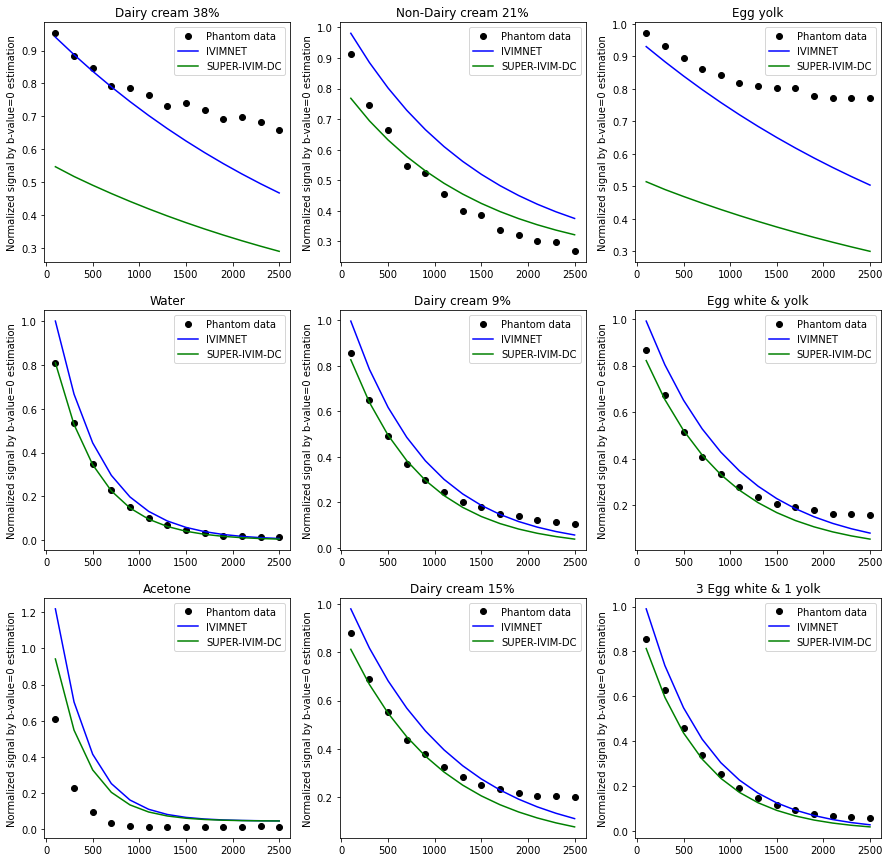

In [3]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
axs = axs.ravel()

CV_stack_Dp_net, CV_stack_Dp_dc = [], []
CV_stack_Dt_net, CV_stack_Dt_dc = [], []
CV_stack_Fp_net, CV_stack_Fp_dc = [], []

for i, (name, phantom_signal) in enumerate(list(ROI_dict.items())):
    phantom_signal = phantom_signal.transpose().reshape(-1, len(bvalues))
    
    #### IVIMNET prediction
    recon_error_net, Dp_net, Dt_net, Fp_net, _ = infer_clinical_supervised_IVIM(phantom_signal, bvalues, ivimnet_path, arg, verbose=VERBOSE_FLAG)

    Dp_net_image = Dp_net.reshape(bbox, bbox).transpose()
    Dt_net_image = Dt_net.reshape(bbox, bbox).transpose()
    Fp_net_image = Fp_net.reshape(bbox, bbox).transpose()
    ivim_out_net = ivim4images(bvalues, Dp_net_image, Dt_net_image, Fp_net_image)
    
    std_net_Dp, mean_net_Dp, CV_net_Dp = Dp_net_image.std(), Dp_net_image.mean(), Dp_net_image.std()/Dp_net_image.mean()
    std_net_Dt, mean_net_Dt, CV_net_Dt = Dt_net_image.std(), Dt_net_image.mean(), Dt_net_image.std()/Dt_net_image.mean()
    std_net_Fp, mean_net_Fp, CV_net_Fp = Fp_net_image.std(), Fp_net_image.mean(), Fp_net_image.std()/Fp_net_image.mean()
    
    #### SUPER IVIM DC predication
    recon_error_DC, Dp_DC, Dt_DC, Fp_DC, S0_DC = infer_clinical_supervised_IVIM(phantom_signal, bvalues, super_ivim_DC_path, arg, verbose=VERBOSE_FLAG)

    Dp_DC_image = Dp_DC.reshape(bbox, bbox).transpose()
    Dt_DC_image = Dt_DC.reshape(bbox, bbox).transpose()
    Fp_DC_image = Fp_DC.reshape(bbox, bbox).transpose()
    S0_DC_image = S0_DC.reshape(bbox, bbox).transpose()
    ivim_out_DC = ivim4images(bvalues, Dp_DC_image, Dt_DC_image, Fp_DC_image)

    std_DC_Dp, mean_DC_Dp, CV_DC_Dp = Dp_DC_image.std(), Dp_DC_image.mean(), Dp_DC_image.std()/Dp_DC_image.mean()
    std_DC_Dt, mean_DC_Dt, CV_DC_Dt = Dt_DC_image.std(), Dt_DC_image.mean(), Dt_DC_image.std()/Dt_DC_image.mean()
    std_DC_Fp, mean_DC_Fp, CV_DC_Fp = Fp_DC_image.std(), Fp_DC_image.mean(), Fp_DC_image.std()/Fp_DC_image.mean()

    selsb = np.array(bvalues) == 100
    phantom_b_100= phantom_signal[:,selsb]     
    S0_factor = 1.19 # not a static value, it needs to bring S0 normleized vlaue to 1, apply only on ROI8
    S0_initial_guess = S0_factor*phantom_signal[:,0].mean()

    # normalized the phantom signal with the guess of S0
    normelized_signal = phantom_signal.mean(axis=0) / S0_initial_guess
    params, _ = curve_fit(ivimN_lsq, bvalues, normelized_signal, p0=[1, 1, 0.1, 1],  maxfev=800)
    S0_lsq = params[3]
    S0_estimation_by_lsq = S0_lsq*S0_initial_guess/phantom_b_100.mean()

    # Dt_lsq, Fp_lsq, Dp_lsq =  params[0] , params[1] , params[2] 

    # real phantom data normalized by the estimated S0
    axs[i].plot(bvalues, phantom_signal.mean(axis=0)/(S0_lsq*S0_initial_guess), 'ko', label="Phantom data")   
    t = np.linspace(0, 2500, 30)# b-values for the fitted model

    axs[i].plot(bvalues, S0_estimation_by_lsq*ivim_out_net.mean(axis=(0,1)), color='blue', label="IVIMNET")
    axs[i].plot(bvalues, S0_estimation_by_lsq*ivim_out_DC.mean(axis=(0,1)), color='green', label="SUPER-IVIM-DC")

    axs[i].legend(loc='upper right')
    axs[i].set_ylabel('Normalized signal by b-value=0 estimation')
    axs[i].set_title(name)

    if i==4:
        print(f'IVIMNET results Dp_net, Dt_net, Fp_net {Dp_net.mean(), Dt_net.mean(), Fp_net.mean()}')
        print(f'SUPER-IVIM-DC results Dp_DC, Dt_DC, Fp_DC {Dp_DC.mean(), Dt_DC.mean(), Fp_DC.mean()}')

    CV_stack_Dp_net.append(CV_net_Dp)
    CV_stack_Dp_dc.append(CV_DC_Dp)

    CV_stack_Dt_net.append(CV_net_Dt)
    CV_stack_Dt_dc.append(CV_DC_Dt)

    CV_stack_Fp_dc.append(CV_DC_Fp)
    CV_stack_Fp_net.append(CV_net_Fp)

<AxesSubplot:ylabel='Coefficient of Variance'>

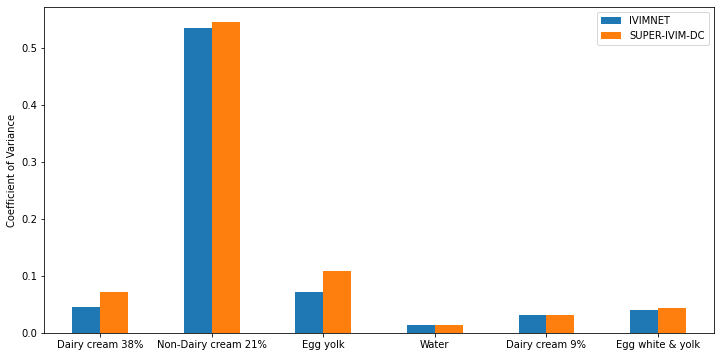

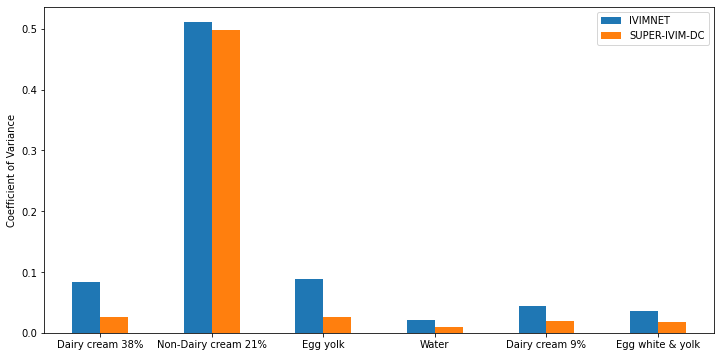

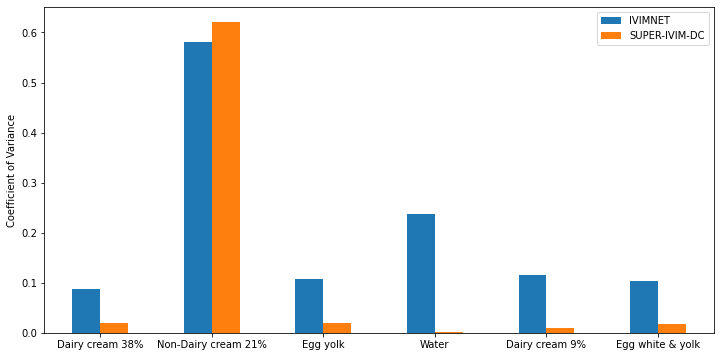

In [4]:
df_Dt = pd.DataFrame(list(zip(CV_stack_Dt_net, CV_stack_Dt_dc)), columns=["IVIMNET", "SUPER-IVIM-DC"], index=ROI_dict.keys())
df_Dt = df_Dt.drop(['Acetone', 'Dairy cream 15%', '3 Egg white & 1 yolk'], axis=0)
df_Dt.plot.bar(rot=0, ylabel='Coefficient of Variance', figsize=(12, 6))

df_Dp = pd.DataFrame(list(zip(CV_stack_Dp_net, CV_stack_Dp_dc)), columns=["IVIMNET", "SUPER-IVIM-DC"], index=ROI_dict.keys())
df_Dp = df_Dp.drop(['Acetone', 'Dairy cream 15%', '3 Egg white & 1 yolk'], axis=0)
df_Dp.plot.bar(rot=0, ylabel='Coefficient of Variance', figsize=(12, 6))

df_Fp = pd.DataFrame(list(zip(CV_stack_Fp_net, CV_stack_Fp_dc)), columns=["IVIMNET", "SUPER-IVIM-DC"], index=ROI_dict.keys())
df_Fp = df_Fp.drop(['Acetone', 'Dairy cream 15%', '3 Egg white & 1 yolk'], axis=0)
df_Fp.plot.bar(rot=0, ylabel='Coefficient of Variance', figsize=(12, 6))

In [5]:
p_val_dairy9_Dp = stats.ttest_ind(CV_stack_Dp_net[4], CV_stack_Dp_dc[4])
reduction_rate_Dp = 100*((CV_stack_Dp_net[4] - CV_stack_Dp_dc[4])/CV_stack_Dp_net[4])

p_val_dairy9_Dt = stats.ttest_ind(CV_stack_Dt_net[4], CV_stack_Dt_dc[4])
reduction_rate_Dt = 100*((CV_stack_Dt_net[4] - CV_stack_Dt_dc[4])/CV_stack_Dt_net[4])

p_val_dairy9_Fp = stats.ttest_ind(CV_stack_Fp_net[4], CV_stack_Fp_dc[4])
reduction_rate_Fp = 100*((CV_stack_Fp_net[4] - CV_stack_Fp_dc[4])/CV_stack_Fp_net[4])


C:\ProgramData\Anaconda3\envs\IVIMNET\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\IVIMNET\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
